# INTRO.

[Turtle Recall: Conservation Challenge](https://zindi.africa/competitions/turtle-recall-conservation-challenge) Just ended on zindi. The aim of this competition was to build a machine learning model to identify individual sea turtles. For each image presented, the model should output the turtle’s unique ID or, if the image corresponds to a new turtle (not present in the database), we identify it as a new turtle. A dataset of labelled photos of turtle faces was provided for the competition.

## Requirements.

Just a basic setup: please use a GPU enabled setup so you don't spend the whole day training the simple model 😉. I used colab pro, the colab free version also works just fine for running this notebook.

### High level Understanding.

For this challenge, we were given a train dataset that contains 100 unique turtles, however we were given another extra data set that contains about 2000 unique turtles. Since the challenge is to predict new turtles asides the 100 turtles, I trained the model on thousands of different turtles, picking images from the extra csv file. After predictions, If the label isn't among the original 100 given, we change the class name to new turtle.

The Approach used was simple classification.

### The Data Given

1. Training data: https://storage.googleapis.com/dm-turtle-recall/train.csv
2. Extra images data: https://storage.googleapis.com/dm-turtle-recall/extra_images.csv
3. Test data: https://storage.googleapis.com/dm-turtle-recall/test.csv
4. Sample submission file: https://storage.googleapis.com/dm-turtle-recall/sample_submission.csv
5. Images: https://storage.googleapis.com/dm-turtle-recall/images.tar

###### Let's Dive In.

Check out your GPU

In [1]:
!nvidia-smi

Fri Apr 22 12:41:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###### Download Unzip and Load in your Dataset

In [2]:
#@title Download images
import os
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


###### Download and  pull CSV files too.

In [3]:
#@title Load train, test and sample_submission

import requests
import io, os
import urllib.parse
import pandas as pd

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'

def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
train_df = read_csv_from_web('train.csv')
test_df = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')
extra_images = read_csv_from_web("extra_images.csv")

# Convert image_location strings to lowercase.
for df in [train_df, test_df]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

print(train_df.shape, test_df.shape, sample_submission.shape)
train_df.head(3)

(2145, 3) (490, 2) (490, 6)


,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw


In my previous notebook on "FastAI bag of Tricks" I explained in details how that the FastAI library is relatively easy to use, there are a bunch of models provided by the library like resnets, densenets, etc. However, the Efficientnet Model is a state of the art model, scaled to 8 different variations B0 to B7. read more [here](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).

Since FastAI does not provide the EfficientNet models, Folks like Luke Melas-Kyriaz have made the corresponding pytorch implementation available, so i can just pip install the library to get the model.

###### Install FastAI and Efficientnet

In [4]:
!pip install -q --upgrade fastcore fastai
!pip install -q efficientnet_pytorch

     |████████████████████████████████| 60 kB 6.2 MB/s 
     |████████████████████████████████| 188 kB 31.4 MB/s 


###### Import corresponding libraries.

In [5]:
import random
import numpy as np
import gc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from efficientnet_pytorch import EfficientNet

###### Preview DataFrame

In [45]:
train_df.tail()

,image_id,image_location,turtle_id
2140,ID_BDMVQH6G,left,t_id_SwQZGIpa
2141,ID_JD58AF27,left,t_id_QqeoI5F3
2142,ID_Y2LJOVUQ,left,t_id_Lhp87PBX
2143,ID_GH1RFB6Z,right,t_id_FBsGDJhU
2144,ID_A4XCXRO9,left,t_id_pCO59rOk



Keep a copy of the train data frame

In [46]:
train_df_orig = train_df.copy()

Import FastAI to check out your version to avoid disparities. As at the time of writing mine was 2.5.6 as long as you are not using version 1.x.x we should be good.

In [7]:
import fastai
print(fastai.__version__ )

2.5.6


In [8]:
from fastai.vision.all import *

###### Set Seed.
We definitely don't want to be in the shoes of those not able to reproduce their score, so let's seed everything seedable....

In [9]:
 def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [10]:
random_seed(2022,True)

###### preview DataFrames

In [11]:
train_df.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [12]:
extra_images.tail()

,image_id,turtle_id
10653,ID_PLYDY39S,t_id_9YXAIhtI
10654,ID_1EJCP0DF,t_id_9YXAIhtI
10655,ID_WXIGYROR,t_id_ajlHbN2F
10656,ID_UAU4GUNK,t_id_ajlHbN2F
10657,ID_Z02Y4N4V,t_id_ajlHbN2F


In [13]:
train_df.tail()

,image_id,image_location,turtle_id
2140,ID_BDMVQH6G,left,t_id_SwQZGIpa
2141,ID_JD58AF27,left,t_id_QqeoI5F3
2142,ID_Y2LJOVUQ,left,t_id_Lhp87PBX
2143,ID_GH1RFB6Z,right,t_id_FBsGDJhU
2144,ID_A4XCXRO9,left,t_id_pCO59rOk


The extra images dataset has exactly 2231 unique classes

In [14]:
len(extra_images.turtle_id.unique())

2231

In [15]:
extra_images.tail()

,image_id,turtle_id
10653,ID_PLYDY39S,t_id_9YXAIhtI
10654,ID_1EJCP0DF,t_id_9YXAIhtI
10655,ID_WXIGYROR,t_id_ajlHbN2F
10656,ID_UAU4GUNK,t_id_ajlHbN2F
10657,ID_Z02Y4N4V,t_id_ajlHbN2F


I didn't use the Image location at all, so I dropped it

In [16]:
train_df = train_df.drop("image_location", axis=1).append(extra_images).reset_index(drop=True)

I created a new column called label count. I didn't intend to use all the Extra data, especially those labels that have small number of images

In [17]:
count_dict = dict(train_df.turtle_id.value_counts())
train_df["label_count"] = [count_dict[x] for x in train_df.turtle_id]

In [18]:
train_df

,image_id,turtle_id,label_count
0,ID_2RK4WLN8,t_id_VP2NW7aV,69
1,ID_VVW0QXLX,t_id_qZ0iZYsC,23
2,ID_RVATH2HZ,t_id_3b65X5Lw,26
3,ID_2GB90GPS,t_id_YjXYTCGC,71
4,ID_LM6S0B1M,t_id_d6aYXtor,11
...,...,...,...
12798,ID_PLYDY39S,t_id_9YXAIhtI,3
12799,ID_1EJCP0DF,t_id_9YXAIhtI,3
12800,ID_WXIGYROR,t_id_ajlHbN2F,3
12801,ID_UAU4GUNK,t_id_ajlHbN2F,3


I'm just simply appending the paths in front of the file name and ".jpg" as a suffix so that the image ids column can contain paths to the image. There are better ways of doing this though......you could even do all this in your data loader......✌

In [19]:
train_df.image_id    = ["/content/turtle_recall/images/"+i+".JPG" for i in train_df.image_id]

In [20]:
train_df

,image_id,turtle_id,label_count
0,/content/turtle_recall/images/ID_2RK4WLN8.JPG,t_id_VP2NW7aV,69
1,/content/turtle_recall/images/ID_VVW0QXLX.JPG,t_id_qZ0iZYsC,23
2,/content/turtle_recall/images/ID_RVATH2HZ.JPG,t_id_3b65X5Lw,26
3,/content/turtle_recall/images/ID_2GB90GPS.JPG,t_id_YjXYTCGC,71
4,/content/turtle_recall/images/ID_LM6S0B1M.JPG,t_id_d6aYXtor,11
...,...,...,...
12798,/content/turtle_recall/images/ID_PLYDY39S.JPG,t_id_9YXAIhtI,3
12799,/content/turtle_recall/images/ID_1EJCP0DF.JPG,t_id_9YXAIhtI,3
12800,/content/turtle_recall/images/ID_WXIGYROR.JPG,t_id_ajlHbN2F,3
12801,/content/turtle_recall/images/ID_UAU4GUNK.JPG,t_id_ajlHbN2F,3


Drop all rows where the number of turtle samples is less than 7. Note that I earlier cheked the miminum number of samples in the original train set which turned out to be 8. This is to ensure I don't drop off some of the original labels. On the other hand, you could decide to train more images, for me i wanted minimum number of samples per image_id to be 7

In [21]:
train_df = train_df[train_df["label_count"]>6].reset_index(drop=True)

In [22]:
train_df

,image_id,turtle_id,label_count
0,/content/turtle_recall/images/ID_2RK4WLN8.JPG,t_id_VP2NW7aV,69
1,/content/turtle_recall/images/ID_VVW0QXLX.JPG,t_id_qZ0iZYsC,23
2,/content/turtle_recall/images/ID_RVATH2HZ.JPG,t_id_3b65X5Lw,26
3,/content/turtle_recall/images/ID_2GB90GPS.JPG,t_id_YjXYTCGC,71
4,/content/turtle_recall/images/ID_LM6S0B1M.JPG,t_id_d6aYXtor,11
...,...,...,...
6219,/content/turtle_recall/images/ID_EGF46109.JPG,t_id_AJMHS9yE,8
6220,/content/turtle_recall/images/ID_QCYQ4I89.JPG,t_id_AJMHS9yE,8
6221,/content/turtle_recall/images/ID_ZSDH16HQ.JPG,t_id_AJMHS9yE,8
6222,/content/turtle_recall/images/ID_6UG4KWQI.JPG,t_id_AJMHS9yE,8


###### Creating your Data block

Remember to checkout the official Fastai [website](https://www.fast.ai/) and [docs](https://docs.fast.ai/) to learn more about FastAI.

Creating a datablock is quite easy, the Datablock API is the foundational block of the dataset creation, you'll have to tell it you are creating a dataset of images, and you'll be using it for a classification task. Hence the Images and category block reference used.

The splitter simply splits your train set into train and validation, Fastai is very serious about overfitting and validation, even if you don't set the splitter, it does that automatically for you using defaults. Personally I prefer the Train_test splitter. It helps me take advantage of the stratification unlike random splits.

-- in case you are wondering, stratification means we are able to split based on class or label.

Next, you'll have to tell the API how to fetch the address of the images, and the respective label for that image. Remember that I've put all these stuff in a nice dataframe

Finally, you can do some transformations for the images. Remember that to train a Convolutional neural network, images are best fitted in when they are of the same size. to this effect, I've told Fastai to squish (not crop) all images to 320 by 320.

When you are done, create an instance of the datablock, the dataloader.

In [23]:
turtle = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.1, stratify=train_df["turtle_id"]),
  get_x = ColReader(0),
  item_tfms=Resize((320,320), method='squish'),
    get_y=ColReader(1),
    batch_tfms = [*aug_transforms(do_flip=True,flip_vert=False,max_lighting=0.4,max_zoom=1.2,max_warp=0.2,max_rotate=30,xtra_tfms=None),Normalize.from_stats(*imagenet_stats)]
    )

In [24]:
dls = turtle.dataloaders(train_df, bs=16, num_workers = 0)

In [25]:
train_df.tail()

,image_id,turtle_id,label_count
6219,/content/turtle_recall/images/ID_EGF46109.JPG,t_id_AJMHS9yE,8
6220,/content/turtle_recall/images/ID_QCYQ4I89.JPG,t_id_AJMHS9yE,8
6221,/content/turtle_recall/images/ID_ZSDH16HQ.JPG,t_id_AJMHS9yE,8
6222,/content/turtle_recall/images/ID_6UG4KWQI.JPG,t_id_AJMHS9yE,8
6223,/content/turtle_recall/images/ID_BM5MJW8P.JPG,t_id_AJMHS9yE,8


Check out one batch

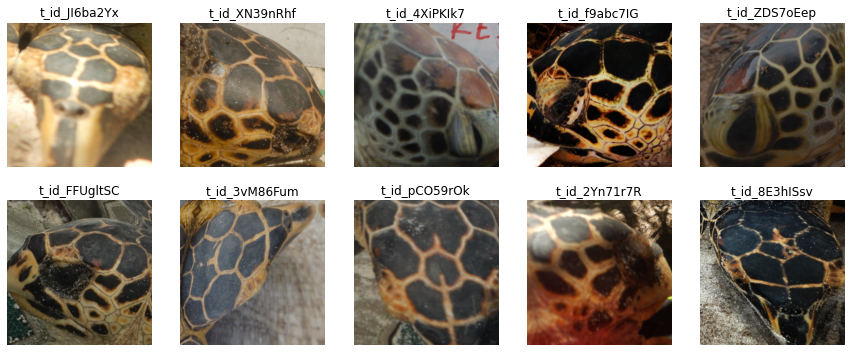

In [29]:
dls.show_batch(max_n=10, nrows=2, ncols=5)

In [30]:
def get_model(dls,pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, dls.c)
    return model

Choose your model, you can choose any of the efficient net series b0 to b7

In [31]:
model_name = 'efficientnet-b6'

In [32]:
learn = Learner(dls, get_model(dls), metrics=[error_rate, accuracy])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


check out what changing the learning rate looks like.

SuggestedLRs(valley=0.0003981071640737355)

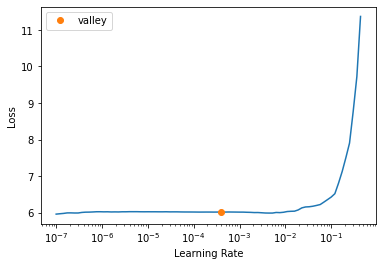

In [33]:
learn.lr_find()

###### Time to Train!!!
I'm using the valid loss callback to ensure I get the best local model. I trained for 20 epochs

In [34]:
learn.fine_tune(20, cbs= SaveModelCallback(monitor='valid_loss'))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.520101,26.127977,0.993579,0.006421,09:21


Better model found at epoch 0 with valid_loss value: 26.12797737121582.


###### Prepare test set for predictions
I also need to change the filename to path so that the dataloader can load it in smoothly.

In [35]:
test_df.image_id    = ["/content/turtle_recall/images/"+i+".JPG" for i in test_df.image_id]

In [36]:
test_df.head()

,image_id,image_location
0,/content/turtle_recall/images/ID_6NEDKOYZ.JPG,top
1,/content/turtle_recall/images/ID_57QZ4S9N.JPG,left
2,/content/turtle_recall/images/ID_OCGGJS5X.JPG,left
3,/content/turtle_recall/images/ID_R2993S3S.JPG,top
4,/content/turtle_recall/images/ID_2E011NB0.JPG,left


###### Use TTA

Sometimes I get too agressive with TTA, here I'm passing n = 15. This means that the dataloader auguments the test image in 15 different ways, performs inference and then averages it.

In [37]:
tdl = learn.dls.test_dl(test_df["image_id"])
test_preds_tta, test_labels_tta = learn.tta(dl=tdl, n=15)

/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [38]:
preds_test = test_preds_tta

The submission format of this competition is an imteresting one, the competition requires you submit your top 5 predictions for each turtle.

For this notebook, I didn't stop at 5 since I trained on about 2000 labels, If I change non_100 turtle names to "new turtles", many of the labels in the row would have new turtle class appearing multiple times, so we'll have to deal with this as it makes no sense for the same turtle-id to appear twice in a row.

You can do as many predictions as you like, however the competition requires just top 5 predictions

In [39]:
class_list = learn.dls.vocab
for n in range(15):
  class_indexes2 = []
  for i in range(len(sample_submission)):
    class_indexes = np.argsort(preds_test, axis=1)[i]
    class_indexes2.append(int(class_indexes[-(n+1)]))
  classes = [class_list[idx] for idx in class_indexes2]


  sample_submission["prediction{}".format(n+1)] = classes

###### Preview the sample submissions

In [40]:
sample_submission

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5,prediction6,prediction7,prediction8,prediction9,prediction10,prediction11,prediction12,prediction13,prediction14,prediction15
0,ID_6NEDKOYZ,t_id_ViX4pu6R,t_id_15bo4NKD,t_id_Pnj3JCZa,t_id_U1gh4ghL,t_id_4dKntPVB,t_id_lt9jQtvW,t_id_FFUgltSC,t_id_Ts5LyVQz,t_id_D7NA71la,t_id_G5JLzvai,t_id_z19EyFm2,t_id_MwnEYfqe,t_id_IlO9BOKc,t_id_uJXT7dGu,t_id_XN39nRhf
1,ID_57QZ4S9N,t_id_15bo4NKD,t_id_U1gh4ghL,t_id_G5JLzvai,t_id_4dKntPVB,t_id_lt9jQtvW,t_id_FFUgltSC,t_id_pCO59rOk,t_id_Ts5LyVQz,t_id_n2FBHk6d,t_id_ViX4pu6R,t_id_XN39nRhf,t_id_m2JvEcsg,t_id_IlO9BOKc,t_id_UHs5o4Dv,t_id_1pAisCFy
2,ID_OCGGJS5X,t_id_U1gh4ghL,t_id_4dKntPVB,t_id_15bo4NKD,t_id_FFUgltSC,t_id_ViX4pu6R,t_id_Pnj3JCZa,t_id_XN39nRhf,t_id_LyqXL5qY,t_id_G5JLzvai,t_id_YjXYTCGC,t_id_Ts5LyVQz,t_id_eb8speoy,t_id_lt9jQtvW,t_id_UHs5o4Dv,t_id_GlcYUlzF
3,ID_R2993S3S,t_id_Pnj3JCZa,t_id_ViX4pu6R,t_id_4dKntPVB,t_id_uJXT7dGu,t_id_U1gh4ghL,t_id_FFUgltSC,t_id_MwnEYfqe,t_id_Ts5LyVQz,t_id_D7NA71la,t_id_z19EyFm2,t_id_hRzOoJ2t,t_id_bYageLYA,t_id_GlcYUlzF,t_id_eb8speoy,t_id_15bo4NKD
4,ID_2E011NB0,t_id_Pnj3JCZa,t_id_4dKntPVB,t_id_U1gh4ghL,t_id_FFUgltSC,t_id_ViX4pu6R,t_id_eb8speoy,t_id_YjXYTCGC,t_id_mYBXCbwF,t_id_LyqXL5qY,t_id_TZSPBtHq,t_id_GlcYUlzF,t_id_uJXT7dGu,t_id_z19EyFm2,t_id_XN39nRhf,t_id_15bo4NKD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,ID_0RVNUKK1,t_id_ViX4pu6R,t_id_Pnj3JCZa,t_id_MwnEYfqe,t_id_z19EyFm2,t_id_4dKntPVB,t_id_D7NA71la,t_id_U1gh4ghL,t_id_bYageLYA,t_id_uJXT7dGu,t_id_FFUgltSC,t_id_Ts5LyVQz,t_id_eb8speoy,t_id_KysHzQQK,t_id_GlcYUlzF,t_id_TeQFNMWD
486,ID_6405IKG3,t_id_Pnj3JCZa,t_id_ViX4pu6R,t_id_4dKntPVB,t_id_MwnEYfqe,t_id_U1gh4ghL,t_id_FFUgltSC,t_id_z19EyFm2,t_id_D7NA71la,t_id_uJXT7dGu,t_id_GlcYUlzF,t_id_TZSPBtHq,t_id_bYageLYA,t_id_Ts5LyVQz,t_id_vAVZTAEk,t_id_TeQFNMWD
487,ID_6WVPVB7S,t_id_Pnj3JCZa,t_id_ViX4pu6R,t_id_4dKntPVB,t_id_MwnEYfqe,t_id_o8HFaaCp,t_id_uJXT7dGu,t_id_GlcYUlzF,t_id_FFUgltSC,t_id_U1gh4ghL,t_id_D7NA71la,t_id_Ts5LyVQz,t_id_z19EyFm2,t_id_hRzOoJ2t,t_id_bYageLYA,t_id_YjXYTCGC
488,ID_47C5LL2G,t_id_ViX4pu6R,t_id_Pnj3JCZa,t_id_4dKntPVB,t_id_U1gh4ghL,t_id_FFUgltSC,t_id_MwnEYfqe,t_id_D7NA71la,t_id_z19EyFm2,t_id_Ts5LyVQz,t_id_15bo4NKD,t_id_eb8speoy,t_id_uJXT7dGu,t_id_bYageLYA,t_id_TeQFNMWD,t_id_Kc1tXDbJ


###### Customize submission

I wrote a custom function to change labels in my submission file, I.E if turtle_id is not among the original 100, we'll just change the name to new_turtle 

In [41]:
def correcter(text):
  if text in list(train_df_orig.turtle_id.values):
    return(text)
  else:
    return("new_turtle")

###### Another Problem!

The issue with approaching the task like this is that at the end, we have several new_turtle class in one row which makes no sense to submit, since it isn't reasonable for the same turtle name to appear twice.

In [42]:
len(sample_submission.columns)

16

###### Apply custom function on submission

In [47]:
for i in ["prediction{}".format(i+1) for i in range(len(sample_submission.columns)-1)]:
  sample_submission[i] = [correcter(i) for i in sample_submission[i]]

###### Preview submission

In [48]:
sample_submission.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5,prediction6,prediction7,prediction8,prediction9,prediction10,prediction11,prediction12,prediction13,prediction14,prediction15
0,ID_6NEDKOYZ,new_turtle,t_id_15bo4NKD,new_turtle,new_turtle,new_turtle,new_turtle,new_turtle,t_id_Ts5LyVQz,t_id_D7NA71la,t_id_G5JLzvai,new_turtle,t_id_MwnEYfqe,t_id_IlO9BOKc,t_id_uJXT7dGu,new_turtle
1,ID_57QZ4S9N,t_id_15bo4NKD,new_turtle,t_id_G5JLzvai,new_turtle,new_turtle,new_turtle,t_id_pCO59rOk,t_id_Ts5LyVQz,t_id_n2FBHk6d,new_turtle,new_turtle,t_id_m2JvEcsg,t_id_IlO9BOKc,new_turtle,new_turtle
2,ID_OCGGJS5X,new_turtle,new_turtle,t_id_15bo4NKD,new_turtle,new_turtle,new_turtle,new_turtle,new_turtle,t_id_G5JLzvai,t_id_YjXYTCGC,t_id_Ts5LyVQz,new_turtle,new_turtle,new_turtle,new_turtle
3,ID_R2993S3S,new_turtle,new_turtle,new_turtle,t_id_uJXT7dGu,new_turtle,new_turtle,t_id_MwnEYfqe,t_id_Ts5LyVQz,t_id_D7NA71la,new_turtle,t_id_hRzOoJ2t,t_id_bYageLYA,new_turtle,new_turtle,t_id_15bo4NKD
4,ID_2E011NB0,new_turtle,new_turtle,new_turtle,new_turtle,new_turtle,new_turtle,t_id_YjXYTCGC,new_turtle,new_turtle,new_turtle,new_turtle,t_id_uJXT7dGu,new_turtle,new_turtle,t_id_15bo4NKD


In [49]:
sample_sub = sample_submission.copy()

###### Solution to repeated classes: 
Pick the unique Items in your long row, and cap it at 5 predictions. Also, ensure you maintain the Order which is super important! the code below does that. so my 15 predictions is capped to 5.

ps: Note that np.unique() sorts the list in ascending order, so you have to keep index to maintain the order of the predictions.

In [50]:
new_frame = []
for each_row in range(len(sample_sub)):
 # print(each_row)
  _, idx  = np.unique(sample_sub[each_row:(each_row+1)].values,return_index=True)
  new_frame.append(sample_sub[each_row:(each_row+1)].values.flatten()[np.sort(idx)][:6].tolist())

Create submission as a data frame and name your columns

In [51]:
final = pd.DataFrame(new_frame)
final.columns = ["image_id"] + ["prediction{}".format(i+1) for i in range(5)]
final.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,t_id_15bo4NKD,t_id_Ts5LyVQz,t_id_D7NA71la,t_id_G5JLzvai
1,ID_57QZ4S9N,t_id_15bo4NKD,new_turtle,t_id_G5JLzvai,t_id_pCO59rOk,t_id_Ts5LyVQz
2,ID_OCGGJS5X,new_turtle,t_id_15bo4NKD,t_id_G5JLzvai,t_id_YjXYTCGC,t_id_Ts5LyVQz
3,ID_R2993S3S,new_turtle,t_id_uJXT7dGu,t_id_MwnEYfqe,t_id_Ts5LyVQz,t_id_D7NA71la
4,ID_2E011NB0,new_turtle,t_id_YjXYTCGC,t_id_uJXT7dGu,t_id_15bo4NKD,None


Download CSV file & submit to Zindi

In [52]:
name = "Submission.csv"
final.to_csv(name, index=False)
from google.colab import files
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###### Tips for Improvement

This is just one of my submissions, I was able to acheive better scores by doing the following.

1. Ensemble submissions using mode.
2. Use better Augmentation techniques
3. Train with more data
4. Clean the dataset, i.e remove poor images
5. Use better models

I am always open to assist enthusiasts with difficulties they are facing in Machine learning and Deep learning. Feel free to reach out to me: most preferably LinkedIn.

. [Twitter](https://twitter.com/Osinkoluolufemi).

. [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

. [Github](https://github.com/osinkolu)

#### Author: Olufemi Victor Tolulope